# 2D XRay Image Registration


 - 어파인 변환 파라미터 예측을 위한, 어파인 헤드를 포함한 U-Net 유사 네트워크

 - 이동 이미지 변환을 위한 MONAI C++/CUDA 모듈로 구현된 warp 함수

## 01. 실습 환경 설정

MONAI 환경 변수 설치 & 최신 버전의 MONAI 설치(with GITHUB)

In [ ]:
%env BUILD_MONAI=1
!python -c "import monai" || pip install -q git+https://github.com/Project-MONAI/MONAI#egg=monai[all]

env: BUILD_MONAI=1
2025-02-02 02:18:54.724842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738462735.011351    6681 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738462735.091053    6681 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 02:18:55.685008: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


데이터 변환 함수 모음
- EnsureChannelFirstD: 의료 영상 데이터 차원 설정
    (H, W) => (C, H, W)
- Compose: 여러 데이터 변환(transforms) 하나로 묶어 순차적 실행 ㄱㄱ
- LoadImageD: 딕셔너리 형태의 데이터 반환(to Tensor)
- RandRotateD: 데이터의 랜덤 회전
- RandZoomD: 이미지의 랜덤 zoom in/out
- ScaleIntensityRanged: 특정 범위 내로 픽셀 정규화

의료 데이터 영상 특성 상, 상당히 규모가 큼!!

-> `CacheDataset` 통해 데이터를 메모리에 캐싱 후 로딩 속도 향상!!

그리고, 영상 정합에는 `GlobalNet` 네트워크 주로 사용!!
이후 `Warp`를 통한 어파인 변환!!

In [ ]:
## 각종 라이브러리 설치
from monai.utils import set_determinism, first          # 실험의 재현성 보장(난수 설정&첫 번째 데이터 가져오기)
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
)
from monai.data import DataLoader, Dataset, CacheDataset        # 데이터 로딩 & 캐싱 관련
from monai.config import print_config, USE_COMPILED         # 환경 출력, 병렬 GPU 연산 설정 관련
from monai.networks.nets import GlobalNet           # 신경망 구조 & 블록
from monai.networks.blocks import Warp          # 의료 영상 정합 모델에서 주로 사용
from monai.apps import MedNISTDataset           # 사전 학습 데이터셋(X-Ray) 로드하기

import numpy as np
import torch
from torch.nn import MSELoss        # 영상 정합에선, 손실 함수로 MSELoss 사용!!
import matplotlib.pyplot as plt
import os
import tempfile


print_config()
set_determinism(42)

MONAI version: 1.4.1rc1+13.g8ac8e0d5
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8ac8e0d52dced4667fcc73812e012078a35e3359
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.25.1
scipy version: 1.13.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: 1.6.2
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.47.1
mlflow version: 2.20.1
pynrrd version: 1.1.3
clearml version: 1.17.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
# 데이터 디렉토리 설정
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpetsdx0ob


좀 디렉토리가 외진 곳에 있긴 하지만...어찌저찌 잘 설치됨!!

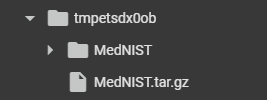

## 실습 데이터 다운받기

***MedNISTDataset***

link: https://medmnist.com/
> MONAI에서 제공하는 실습용 의료 영상 데이터셋으로, 여러 가지 카테고리 보유!!

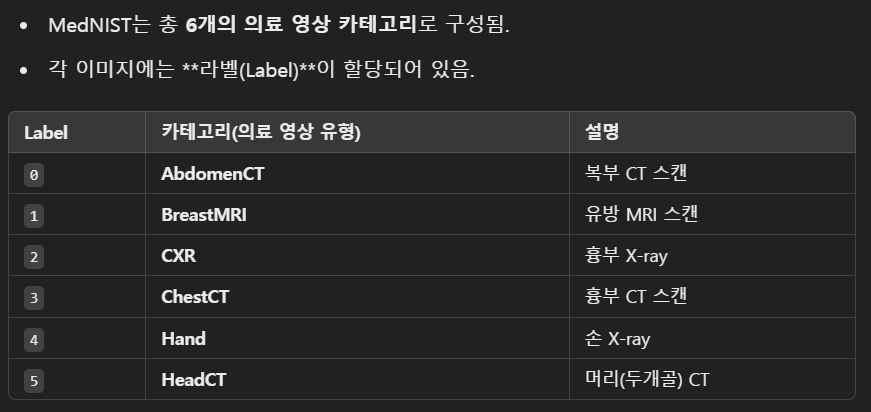

Construct Pairwise Training Inputs

- `{"fixed_hand": item["image"], "moving_hand": item["image"]}` : 여기서 일단 고정 이미지 & 이동 이미지를 동일하게 설정!!

> 실제 실습은, moving hand를 어파인 변형하여 fixed image에 맞추는 거!!

In [ ]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, transform=None)
training_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in train_data.data
    if item["label"] == 4  # label 4 is for xray hands
]
print("\n first training items: ", training_datadict[:3])       # 첫 4개 데이터만 출력해서 ㄱㄱ

MedNIST.tar.gz: 59.0MB [00:02, 30.9MB/s]                            

2025-02-02 02:20:55,399 - INFO - Downloaded: /tmp/tmpetsdx0ob/MedNIST.tar.gz


2025-02-02 02:20:55,558 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-02-02 02:20:55,561 - INFO - Writing into directory: /tmp/tmpetsdx0ob.


Loading dataset: 100%|██████████| 47164/47164 [00:00<00:00, 119263.32it/s]


 first training items:  [{'fixed_hand': '/tmp/tmpetsdx0ob/MedNIST/Hand/003857.jpeg', 'moving_hand': '/tmp/tmpetsdx0ob/MedNIST/Hand/003857.jpeg'}, {'fixed_hand': '/tmp/tmpetsdx0ob/MedNIST/Hand/006587.jpeg', 'moving_hand': '/tmp/tmpetsdx0ob/MedNIST/Hand/006587.jpeg'}, {'fixed_hand': '/tmp/tmpetsdx0ob/MedNIST/Hand/007599.jpeg', 'moving_hand': '/tmp/tmpetsdx0ob/MedNIST/Hand/007599.jpeg'}]


데이터 변환(증강) 파이프라인 구현

- RandRotate: 어파인 변환
- RandZoom: 스케일링 변환

In [ ]:
train_transforms = Compose(
    [
        LoadImageD(keys=["fixed_hand", "moving_hand"]),
        EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
        ScaleIntensityRanged(
            keys=["fixed_hand", "moving_hand"],
            a_min=0.0,
            a_max=255.0,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        RandRotateD(keys=["moving_hand"], range_x=np.pi / 4, prob=1.0, keep_size=True, mode="bicubic"),
        RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
    ]
)

## 데이터 시각화

Visualization of the **training pairs**

- warping을 사용하여, Moving Image를 Fixed Image와 정렬한다(feat. Affine 변환)

moving_image shape: torch.Size([64, 64])
fixed_image shape: torch.Size([64, 64])


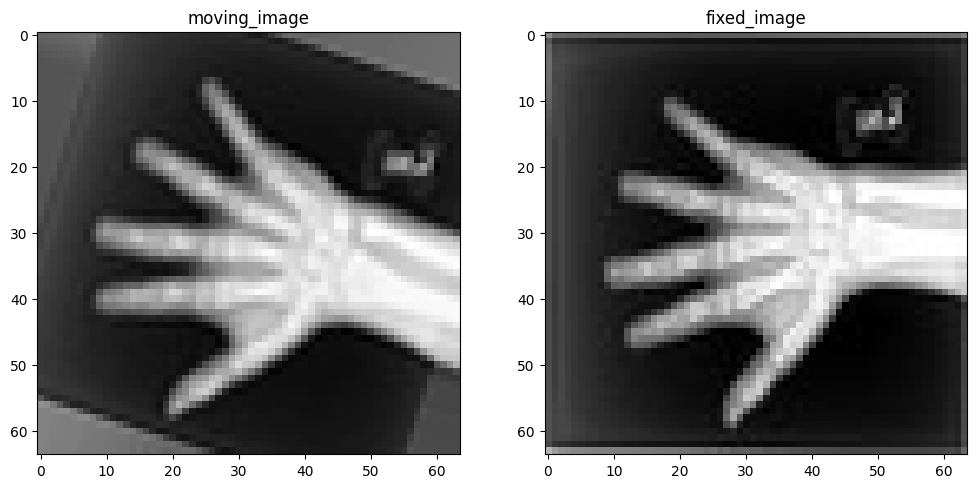

In [ ]:
check_ds = Dataset(data=training_datadict, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)
fixed_image = check_data["fixed_hand"][0][0]
moving_image = check_data["moving_hand"][0][0]

print(f"moving_image shape: {moving_image.shape}")
print(f"fixed_image shape: {fixed_image.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("moving_image")
plt.imshow(moving_image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("fixed_image")
plt.imshow(fixed_image, cmap="gray")

plt.show()

## Training Pipeline 개설하기



- `CacheDataset`: 학습 데이터 저장 & 학습 속도 up
- `GlobalNet`: 이미지 수준의 Affine 변환 파라미터 예측
- Warp 레이어 초기화 -> 학습 및 추론 과정에서 활용!!

In [ ]:
train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)

Loading dataset: 100%|██████████| 1000/1000 [00:03<00:00, 279.26it/s]


`GlobalNet`: Moving Image를 Fixed Image와 정렬하는 변환
학습(with Affine 변환)

* input image size: (64, 64)
    
    - Moving Image, Fixed Image 둘 다 입력(하나의 2차원 입력 텐서로 결합 후에..)
* spatial_dims: 2D 이미지 처리 위한 CNN
* in_channels=2 => [fixed_image, moving_image]
* num_channel_initial: UNet의 첫 번째 Conv.layer 수
* depth: UNet 구조의 깊이



> 일반적인 Encoder-Decoder 구조와 달리, 인코더만 사용하여 **어파인 변환 행렬**의 예측에 집중!!



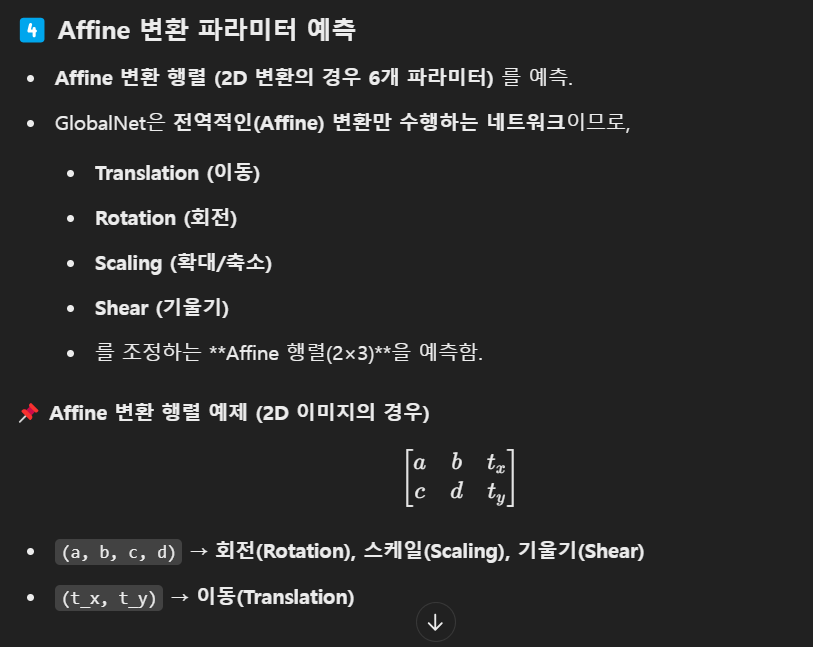

구조) Input -> UNet 인코더(컨볼루션+MaxPool) -> BottleNeck -> 어파인 행렬 구조 출력(Warp)

In [ ]:
device = torch.device("cuda:0")

# 모델은 GlobalNet 선언
model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2,
    num_channel_initial=16,
    depth=3  # moving and fixed
).to(device)
image_loss = MSELoss()

# Warp 레이어 초기화 조건
if USE_COMPILED:
    warp_layer = Warp(3, "border").to(device)       # 3차 보간법(고성능 최적화)
else:
    warp_layer = Warp("bilinear", "border").to(device)      # 2차 보간법
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

Training Loop

In [ ]:
max_epochs = 200
epoch_loss_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss, step = 0, 0
    for batch_data in train_loader:
        step += 1
        optimizer.zero_grad()

        moving = batch_data["moving_hand"].to(device)
        fixed = batch_data["fixed_hand"].to(device)
        ddf = model(torch.cat((moving, fixed), dim=1))
        pred_image = warp_layer(moving, ddf)

        loss = image_loss(pred_image, fixed)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
        #       f"train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

----------
epoch 1/200
epoch 1 average loss: 0.0106
----------
epoch 2/200
epoch 2 average loss: 0.0116
----------
epoch 3/200
epoch 3 average loss: 0.0124
----------
epoch 4/200
epoch 4 average loss: 0.0123
----------
epoch 5/200
epoch 5 average loss: 0.0108
----------
epoch 6/200
epoch 6 average loss: 0.0114
----------
epoch 7/200
epoch 7 average loss: 0.0110
----------
epoch 8/200
epoch 8 average loss: 0.0108
----------
epoch 9/200
epoch 9 average loss: 0.0111
----------
epoch 10/200
epoch 10 average loss: 0.0133
----------
epoch 11/200
epoch 11 average loss: 0.0117
----------
epoch 12/200
epoch 12 average loss: 0.0130
----------
epoch 13/200
epoch 13 average loss: 0.0117
----------
epoch 14/200
epoch 14 average loss: 0.0111
----------
epoch 15/200
epoch 15 average loss: 0.0111
----------
epoch 16/200
epoch 16 average loss: 0.0107
----------
epoch 17/200
epoch 17 average loss: 0.0103
----------
epoch 18/200
epoch 18 average loss: 0.0103
----------
epoch 19/200
epoch 19 average loss:

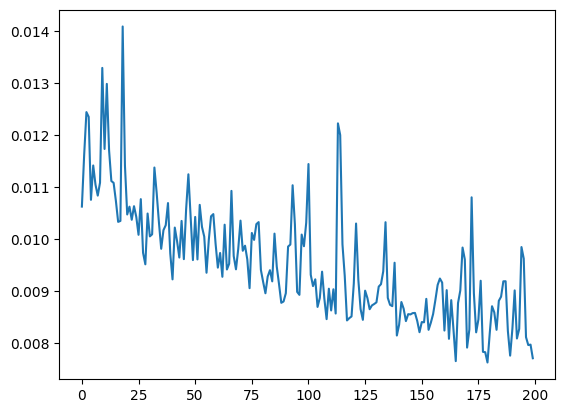

In [ ]:
%matplotlib inline
plt.plot(epoch_loss_values)

## Validation Process

Visualize some validation results

In [ ]:
val_ds = CacheDataset(data=training_datadict[2000:2500], transform=train_transforms, cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=0)
for batch_data in val_loader:
    moving = batch_data["moving_hand"].to(device)
    fixed = batch_data["fixed_hand"].to(device)
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]

Loading dataset: 100%|██████████| 500/500 [00:01<00:00, 481.29it/s]


정합 결과 시각화!!

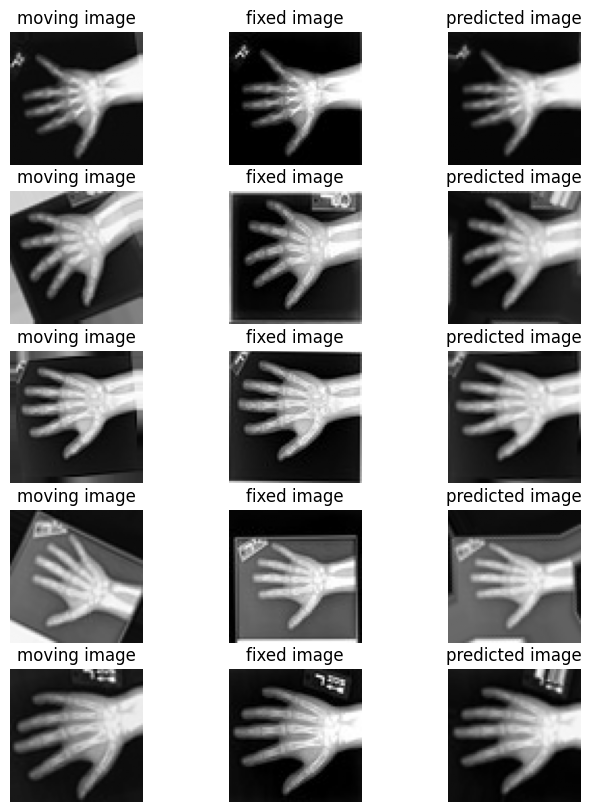

In [ ]:
%matplotlib inline
batch_size = 5
plt.subplots(batch_size, 3, figsize=(8, 10))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 3, b * 3 + 1)
    plt.axis("off")
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 3, b * 3 + 2)
    plt.axis("off")
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 3, b * 3 + 3)
    plt.axis("off")
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
plt.axis("off")
plt.show()